In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Carga de datos

In [3]:
melbourne_file_path = "train.csv"
melbourne_data = pd.read_csv(melbourne_file_path) 

In [4]:
melbourne_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
melbourne_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Exploración Inicial

In [6]:
melbourne_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


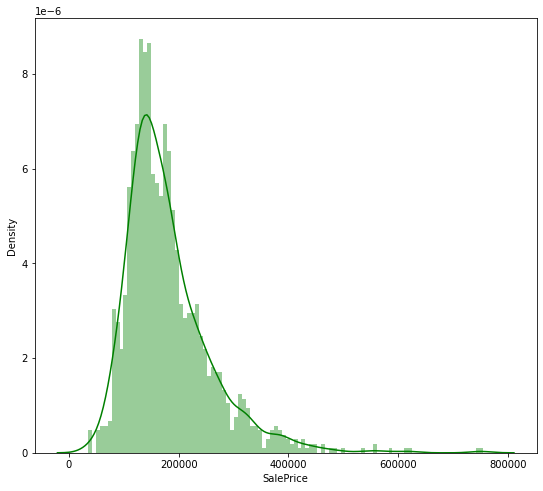

In [7]:
plt.figure(figsize=(9, 8))
sns.distplot(melbourne_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [8]:
nan_info = pd.DataFrame({'NaN Count': melbourne_data.isna().sum(), '% NaN': (melbourne_data.isna().mean() * 100)})
nan_info_filtered = nan_info[(nan_info['NaN Count'] > 0) | (nan_info['% NaN'] > 0)]
nan_info_filtered

,NaN Count,% NaN
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740
Electrical,1,0.068493


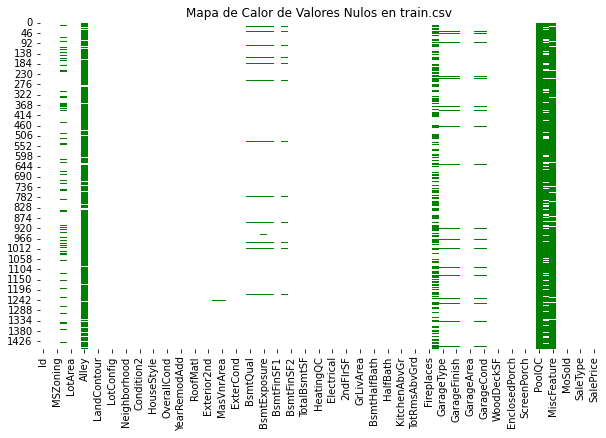

In [9]:
# Mapa de calor de valores nulos en el DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(melbourne_data.isnull(), cbar=False, cmap=sns.color_palette(['white','green']))

plt.title('Mapa de Calor de Valores Nulos en train.csv')
plt.show()

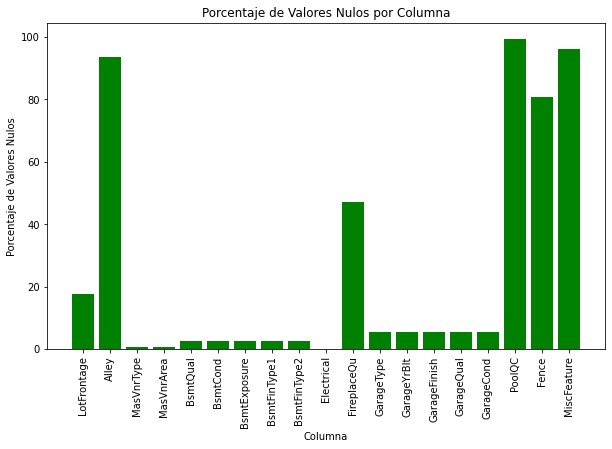

In [10]:
# Porcentaje de valores nulos en las columnas con valores faltantes
null_counts = melbourne_data.isnull().sum()
null_columns = null_counts[null_counts > 0]
null_percentage = (null_columns / len(melbourne_data)) * 100

plt.figure(figsize=(10, 6))
plt.bar(null_percentage.index, null_percentage, color='green')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.xlabel('Columna')
plt.ylabel('Porcentaje de Valores Nulos')
plt.xticks(rotation=90)
plt.show()

### Imputación de valores faltantes

In [11]:
# Elimino éstas columnas categóricas con más del 50 % de NaN
melbourne_data = melbourne_data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature']) 
melbourne_data.drop(columns='Id', inplace=True)

In [12]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_columns = melbourne_data.select_dtypes(include='number').columns
num_columns = num_columns.drop('SalePrice')
# num_columns = num_columns.to_list()
cat_columns = melbourne_data.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ])

# Creo el pipeline 
pipeline = Pipeline([
    ('preprocessor', preprocessor)
    ])

# Aplico el pipeline al dataset
X = melbourne_data.drop('SalePrice', axis=1)
y = np.log(melbourne_data['SalePrice'])  # Normalización
X_preprocessed = pipeline.fit_transform(X)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Ajuste y evaluación los modelos

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30]
        }
    },
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5]
        }
    }
}

best_models = {}

# Itera a través del diccionario param_grids para ajustar los modelos y obtener los mejores hiperparámetros
for model_name, model_info in param_grids.items():
    model = model_info['model']
    params = model_info['params']
    
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Mejores hiperparámetros para {model_name}:", best_params)
    best_models[model_name] = best_model

# Modelos con los mejores modelos ajustados
models = best_models

Mejores hiperparámetros para Random Forest: {'max_depth': 30, 'n_estimators': 300}
Mejores hiperparámetros para Linear Regression: {'fit_intercept': True}
Mejores hiperparámetros para XGBoost: {'max_depth': 3, 'n_estimators': 300}


### Entrenar los modelos

In [14]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) 
       
    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print(f"Mean Absolut Error (MAE): {mae:.2f}")
    print()

Model: Random Forest
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.89
Mean Absolut Error (MAE): 0.10

Model: Linear Regression
Mean Squared Error (MSE): 110446932718708.50
R-squared (R2): -591848509988392.62
Mean Absolut Error (MAE): 857950.81

Model: XGBoost
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.89
Mean Absolut Error (MAE): 0.10



### Interpretación de los resultados

1. Random Forest:

MSE: 0.02
R2: 0.89
Estos resultados indican que el modelo de Random Forest tiene un MSE bajo (0.02) y un R2 alto (0.89), lo que sugiere que el modelo se ajusta bien a los datos de prueba y puede hacer buenas predicciones.

2. Linear Regression:

MSE: 110446932718708.50
R2: -591848509988392.62
Los resultados para la regresión lineal son inusualmente grandes. El MSE es extremadamente alto y el R2 es negativo, lo que sugiere que este modelo de regresión lineal no se ajusta bien a los datos de prueba. 

3. XGBoost:

MSE: 0.02
R2: 0.89
Los resultados para XGBoost son similares a los de Random Forest, con un MSE bajo (0.02) y un R2 alto (0.89), lo que sugiere que el modelo de XGBoost también se ajusta bien a los datos de prueba.


Los valores del Mean Absolute Error (MAE) son consistentes y se mantienen en 0.10 en todos los modelos antes de aplicar PCA. Esto indica que el error promedio absoluto de las predicciones es relativamente estable entre los modelos y está en ese rango específico.

In [15]:
from sklearn.decomposition import PCA

# Aplico PCA para reducir la dimensionalidad
pca = PCA()  
X_processed_pca = pca.fit_transform(X_preprocessed)


# Calculo la varianza acumulada explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Defino un umbral de varianza explicada deseado (conservo el 95% de la varianza)
desired_variance = 0.95

# Determino el número de componentes principales que cumplan con el umbral deseado
num_components_desired = np.argmax(cumulative_explained_variance >= desired_variance) + 1

# Aplico PCA nuevamente con el número de componentes seleccionado
pca = PCA(n_components=num_components_desired)
X_processed_pca = pca.fit_transform(X_preprocessed)

pipeline_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
])

X_pca = pipeline_pca.fit_transform(X)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Corro los mismos modelos con la nueva información

In [16]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30]
        }
    },
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5]
        }
    }
}

best_models = {}

# Iterar a través del diccionario param_grids para ajustar los modelos y obtener los mejores hiperparámetros
for model_name, model_info in param_grids.items():
    model = model_info['model']
    params = model_info['params']
    

    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_pca, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Mejores hiperparámetros para {model_name}:", best_params)
    best_models[model_name] = best_model

Mejores hiperparámetros para Random Forest: {'max_depth': 30, 'n_estimators': 100}
Mejores hiperparámetros para Linear Regression: {'fit_intercept': True}
Mejores hiperparámetros para XGBoost: {'max_depth': 3, 'n_estimators': 100}


In [17]:
# Modelos con los mejores ya ajustados
models_pca = best_models

for model_name, model in models_pca.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) 

    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print(f"Mean Absolut Error (MAE): {mae:.2f}")
    print()


Model: Random Forest
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.88
Mean Absolut Error (MAE): 0.10

Model: Linear Regression
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.89
Mean Absolut Error (MAE): 0.10

Model: XGBoost
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.88
Mean Absolut Error (MAE): 0.10



### Análisis de los resultados luego de aplicar PCA

 Después de aplicar PCA, los modelos mantienen un rendimiento similar en términos de MSE, R2 y MAE en comparación con los resultados anteriores a la aplicación de PCA. Esto sugiere que la reducción de dimensionalidad proporcionada por PCA no ha tenido un impacto significativo en el rendimiento de los modelos en este caso particular.

### Carga y exploración del data test


In [18]:
test_data = pd.read_csv("test.csv") 

In [19]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [22]:
nan_info_test = pd.DataFrame({'NaN Count': test_data.isna().sum(), '% NaN': (test_data.isna().mean() * 100)})
nan_info_filtered_test = nan_info_test[(nan_info_test['NaN Count'] > 0) | (nan_info_test['% NaN'] > 0)]
nan_info_filtered_test

,NaN Count,% NaN
MSZoning,4,0.274160
LotFrontage,227,15.558602
Alley,1352,92.666210
Utilities,2,0.137080
Exterior1st,1,0.068540
Exterior2nd,1,0.068540
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
BsmtQual,44,3.015764
BsmtCond,45,3.084304


In [ ]:
test_data = test_data.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'])

### Preposesamiento y escalado sobre el data test

In [41]:
predictions_df = pd.DataFrame()
predictions_df["Id"] = test_data["Id"]


In [42]:
'''models = best_models

for model_name, model in models.items():
    y_pred = model.predict(X_test_pca)
    predictions_df["SalePrice"] = y_pred 
    # Agregar la columna de predicciones al DataFrame
    predictions_df["Predicted_" + model_name] = predictions_df['SalePrice']

# Puedes guardar las predicciones en un archivo CSV
predictions_df.to_csv("predictions.csv", index=False)'''

In [54]:
# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame()
predictions_df["Id"] = test_data["Id"]

# Inicializar variables para el mejor modelo y su rendimiento
mejor_modelo = None
mejor_score = float('-inf')

# Selecciona el modelo de Regresión Lineal
modelo_linear_regression = best_models['Linear Regression']

# Realizar predicciones con el modelo de Regresión Lineal
y_pred_linear_regression = modelo_linear_regression.predict(X_test_pca)

# Calcular el rendimiento del modelo de Regresión Lineal en los datos de prueba (por ejemplo, R-cuadrado)
r2_score_linear_regression = modelo_linear_regression.score(X_test_pca, y_pred_linear_regression)

# Si el rendimiento del modelo de Regresión Lineal es mejor que el mejor modelo anterior, actualizar el mejor modelo
if r2_score_linear_regression > mejor_score:
    mejor_modelo = modelo_linear_regression
    mejor_score = r2_score_linear_regression
    
    # Actualizar las predicciones con las del mejor modelo hasta ahora
    predictions_df["SalePrice"] = y_pred_linear_regression

# Guardar las predicciones del mejor modelo (Regresión Lineal) en un archivo CSV
predictions_df.to_csv("submission_linear_regression.csv", index=False)

